In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(1234)

import logging
logger = logging.getLogger('pystan')
logger.addHandler(logging.NullHandler())

import pystan
import scipy.stats as stats
import arviz

%matplotlib inline
%precision 4
plt.style.use('ggplot')

# This library is needed for building Stan files in notebooks
import nest_asyncio
nest_asyncio.apply()

# This library is needed for multichain MCMC
import multiprocessing
multiprocessing.set_start_method("fork")

# Task Description

$a_{t} \in \{R, L\} (t = 1, ..., T)$

$r_{t} \in \{0, 1\} (t = 1, ..., T)$

In [2]:
df = pd.read_csv("./data/two_choice_task.csv")
actions = np.array(df["Choice (0: Left, 1: Right)"])
rewards = np.array(df["Outcome (0: Omission, 1: Rewarded)"])
rp_left = np.array(df["Reward Probability of the Left"])
rp_right = np.array(df["Reward Probability of the Right"])
df

,"Choice (0: Left, 1: Right)","Outcome (0: Omission, 1: Rewarded)",Reward Probability of the Left,Reward Probability of the Right
0,0,0,0.7,0.3
1,0,1,0.7,0.3
2,0,1,0.7,0.3
3,0,0,0.7,0.3
4,0,0,0.7,0.3
...,...,...,...,...
427,1,0,0.3,0.7
428,1,1,0.3,0.7
429,1,1,0.3,0.7
430,1,1,0.3,0.7


# Behavior Modeling 1: Logistic Regression Model

Logistic regression model to estimate effects of outcome history

$\log(\dfrac{P(a_{t}=R)}{1-P(a_{t}=R)})=\beta_{0} + \sum_{i=1}^{N}\beta_{i}R(t-i)$

- $R(t)= 1$ (If $a_{t} = R$ and $r_{t} = 1$)
- $R(t)= -1$ (If $a_{t} = L$ and $r_{t} = 1$)
- $R(t)= 0$ (If $r_{t} = 0$)

In [73]:
stan_lr = """
data {
  int<lower=1> T;                // Number of trials
  int<lower=1> N;                // History length
  int<lower=0,upper=1> a[T];                     // Actions (0: Left, 1: Right)
  real r[T];                     // Rewards
}

parameters {
  vector[N+1] betas;
}

model {
  vector[T-N] q;
  
  // Priors
  betas ~ normal(0, 10);
  
  // Using 'for' iteration for time-series computation
  for ( t in N+1:T ) {
    q[t-N] = betas[1];
    for (i in 1:N) {
      q[t-N] = q[t-N] + betas[i+1] * (2*a[t-i]-1);
    }
    a[t] ~ bernoulli_logit(q[t-N]);
  }
}
"""

In [74]:
data_lr = {
    "T": len(actions),
    "N": 5,
    "a": actions,
    "r": rewards
}

In [ ]:
sm = pystan.StanModel(model_code=stan_lr)

In [ ]:
sample_kwargs = {"iter": 5000, "chains": 4, "warmup": 2000}
fit = sm.sampling(data=data_lr, **sample_kwargs)
lr_ll = np.mean(fit["lp__"])

In [78]:
print(fit)

Inference for Stan model: anon_model_17fb1dbe072d24bf8677ab5dea8e9634.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

            mean se_mean     sd   2.5%    25%     50%     75%  97.5%  n_eff   Rhat
betas[1] -2.7e-3  1.3e-3   0.15  -0.29   -0.1 -2.6e-3    0.09   0.28  12975    1.0
betas[2]    1.24  1.5e-3   0.17   0.92   1.13    1.24    1.35   1.57  12558    1.0
betas[3]    0.77  1.8e-3   0.19    0.4   0.64    0.77     0.9   1.15  11044    1.0
betas[4]     0.3  2.0e-3   0.21  -0.11   0.16     0.3    0.44    0.7  11041    1.0
betas[5]   -0.16  2.3e-3   0.23  -0.62  -0.31   -0.15 -2.3e-3   0.28   9862    1.0
betas[6]    0.23  2.0e-3    0.2  -0.17   0.09    0.23    0.37   0.61  10600    1.0
lp__      -159.6    0.02   1.74 -163.9 -160.5  -159.3  -158.3 -157.2   5736    1.0

Samples were drawn using NUTS at Wed Jun  8 11:44:13 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the

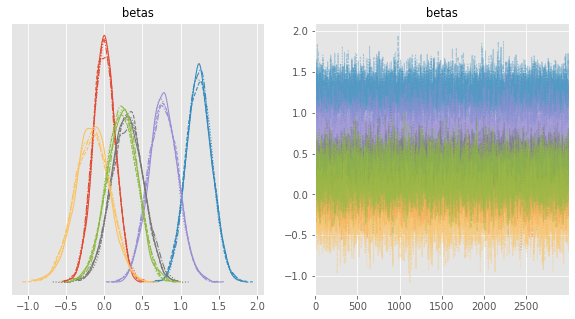

In [84]:
arviz.plot_trace(fit, var_names=('betas'), figsize=(10, 5));

# Behavior Modeling 2: Reinforcement Learning Model

## Model 1: Q-Learning Model

Parameters:
- $\alpha$: Learning rate
- $\beta$: Inverse temperature

Model explaination:
- $Q(a, t)$: Action value for action $a$ at time $t$. ($a \in \{R, L\}$)
- Predicted action probability: $P(a_{t}=R) = \dfrac{1.0}{1.0 + \exp[-\beta (Q(R, t) - Q(L, t))]}$
- Value update (i.e $a_{t}=R$):
$\begin{equation}
\left\{ \,
    \begin{aligned}
    & Q(R, t+1) = (1-\alpha)Q(R, t) + \alpha r_{t} \\
    & Q(L, t+1) = Q(L, t)
    \end{aligned}
\right.
\end{equation}$

Prior settings:
- Since $\alpha$ should be upper than 0 but lower than 1, we assume the Beta distribution as $\alpha$'s prior.
- Since $\beta$ should be non-negative real value, we assume the Gamma distribution as $\beta$'s prior.

$\begin{equation}
\left\{ \,
    \begin{aligned}
    & \alpha \sim Beta(2, 2) \\
    & \beta \sim Gamma(2, 3)
    \end{aligned}
\right.
\end{equation}$

Likelihood $P(A_{1:T}, R_{1:T}|\alpha, \beta)$:

$P(A_{1:T}, R_{1:T}|\alpha, \beta) = \prod_{t=1}^{T}P(a_{t}=A_{t}|A_{1:t-1}, R_{1:t-1}, \alpha, \beta)$

where $P(a_{t}=A_{t}|A_{1:t-1}, R_{1:t-1}, \alpha, \beta) = \dfrac{1.0}{1.0 + \exp[-\beta (Q(A_{t}, t) - Q(\bar{A}_{t}, t))]}$

Using "target +="

In [31]:
stan_q = """
data {
  int<lower=1> T ;               // Number of trials
  int<lower=1,upper=2> a[T];     // Actions (1: Left, 2: Right)
  real r[T];                     // Rewards
}

parameters {
  real<lower=0.0,upper=1.0> alpha;  // Learning rate
  real<lower=0.0> beta;             // Inverse temperature
}

model {
  matrix[2,T] Q; // Action values
  Q[1, 1] = 0;
  Q[2, 1] = 0;
  
  // Priors
  alpha ~ beta(2, 2);
  beta ~ gamma(2, 3);
  
  // Using 'for' iteration for time-series computation
  for ( t in 1:T ) {
    // Action selection
    // Adding a log-likelihood of a predicted action to "target"
    target += log( 1.0 / ( 1.0 + exp( -beta * (Q[a[t],t] - Q[3-a[t],t]) ) ) );
    
    // Value update
    if (t < T) {
      Q[a[t], t+1] = (1.0 - alpha) * Q[a[t], t] + alpha * r[t]; // Value update for a chosen action
      Q[3-a[t], t+1] = Q[3-a[t], t];                            // Value update for a unchosen action
    }
  }
}
"""

In [32]:
data_q = {
    "T": len(actions),
    "a": actions+1,
    "r": rewards
}

In [ ]:
sm = pystan.StanModel(model_code=stan_q)

In [ ]:
sample_kwargs = {"iter": 5000, "chains": 4, "warmup": 2000}
fit = sm.sampling(data=data_q, **sample_kwargs)
q_ll = np.mean(fit["lp__"])

In [35]:
print(fit)

Inference for Stan model: anon_model_91bb14310378077a541cf3c61753e088.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.51  1.1e-3   0.08   0.34   0.45    0.5   0.56   0.67   5411    1.0
beta    2.73  4.5e-3   0.31   2.14   2.52   2.72   2.94   3.37   4925    1.0
lp__  -222.4    0.02   1.07 -225.2 -222.8 -222.0 -221.6 -221.3   4789    1.0

Samples were drawn using NUTS at Wed Jun  8 10:35:13 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


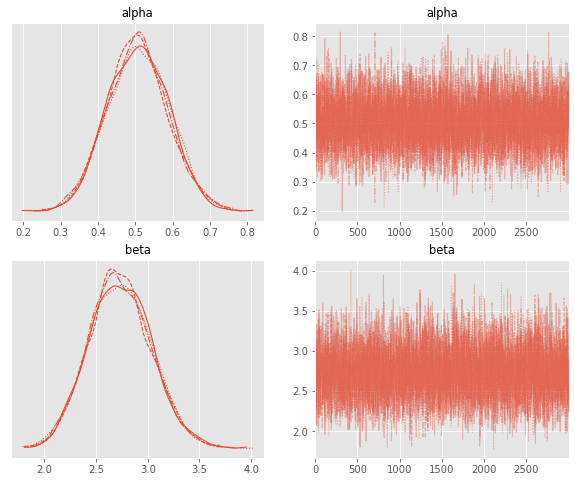

In [21]:
arviz.plot_trace(fit, var_names=('alpha', 'beta'), figsize=(10, 8));

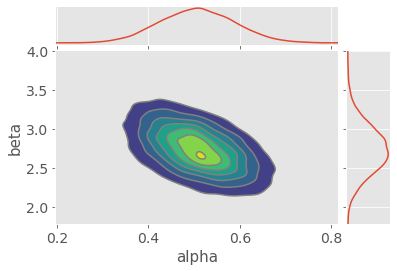

In [22]:
arviz.plot_pair(
    fit,
    var_names=['alpha', 'beta'],
    kind="kde",
    marginals=True
)
plt.show()

## Model 2: Q-Learning Model with Forgetting

Parameters:
- $\alpha$: Learning rate
- $\alpha_{F}$: Forgetting rate (How much information a subject forgets about an unselected choice at a previous trial)
- $\beta$: Inverse temperature

Model explaination:
- $Q(a, t)$: Action value for action $a$ at time $t$. ($a \in \{R, L\}$)
- Action selection: $P(a_{t}=R) = \dfrac{\exp(-\beta Q(R, t))}{\exp(-\beta Q(R, t)) + \exp(-\beta Q(L, t))}$
- Value update (i.e $a_{t}=R$):
$\begin{equation}
\left\{ \,
    \begin{aligned}
    & Q(R, t+1) = (1-\alpha)Q(R, t) + \alpha r_{t} \\
    & Q(L, t+1) = (1-\alpha_{F})Q(L, t)
    \end{aligned}
\right.
\end{equation}$

Prior settings:
$\begin{equation}
\left\{ \,
    \begin{aligned}
    & \alpha \sim Beta(2, 2) \\
    & \alpha_{F} \sim Beta(2, 2) \\
    & \beta \sim Gamma(2, 3)
    \end{aligned}
\right.
\end{equation}$

In [36]:
stan_qf = """
data {
  int<lower=1> T ;               // Number of trials
  int<lower=1,upper=2> a[T];     // Actions (1: Left, 2: Right)
  real r[T];                     // Rewards
}

parameters {
  real<lower=0.0,upper=1.0> alpha;  // Learning rate
  real<lower=0.0,upper=1.0> alpha_F;  // Forgetting rate
  real<lower=0.0> beta;             // Inverse temperature
}

model {
  matrix[2,T] Q; // Action values
  Q[1, 1] = 0;
  Q[2, 1] = 0;
  
  // Priors
  alpha ~ beta(2, 2);
  alpha_F ~ beta(2, 2);
  beta ~ gamma(2, 3);
  
  // Using 'for' iteration for time-series computation
  for ( t in 1:T ) {
    // Action selection
    // Adding a log-likelihood of a predicted action to "target"
    target += log( 1.0 / ( 1.0 + exp( -beta * (Q[a[t],t] - Q[3-a[t],t]) ) ) );
    
    // Value update
    if (t < T) {
      Q[a[t], t+1] = (1.0 - alpha) * Q[a[t], t] + alpha * r[t]; // Value update for a chosen action
      Q[3-a[t], t+1] = (1.0 - alpha_F) * Q[3-a[t], t];          // Value update for a unchosen action
    }
  }
}
"""

In [37]:
data_qf = {
    "T": len(actions),
    "a": actions+1,
    "r": rewards
}

In [ ]:
sm = pystan.StanModel(model_code=stan_qf)

In [ ]:
sample_kwargs = {"iter": 5000, "chains": 4, "warmup": 2000}
fit = sm.sampling(data=data_qf, **sample_kwargs)
qf_ll = np.mean(fit["lp__"])

In [40]:
print(fit)

Inference for Stan model: anon_model_75ca641457e1338f0de2f151c9b3e96f.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.31  6.1e-4   0.06   0.21   0.27   0.31   0.35   0.43   8313    1.0
alpha_F   0.81  9.6e-4    0.1   0.59   0.75   0.82   0.89   0.97  10446    1.0
beta      4.33  4.6e-3   0.41   3.56   4.04   4.32    4.6   5.18   8060    1.0
lp__    -168.0    0.02   1.27 -171.3 -168.6 -167.7 -167.1 -166.5   4999    1.0

Samples were drawn using NUTS at Wed Jun  8 10:36:26 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


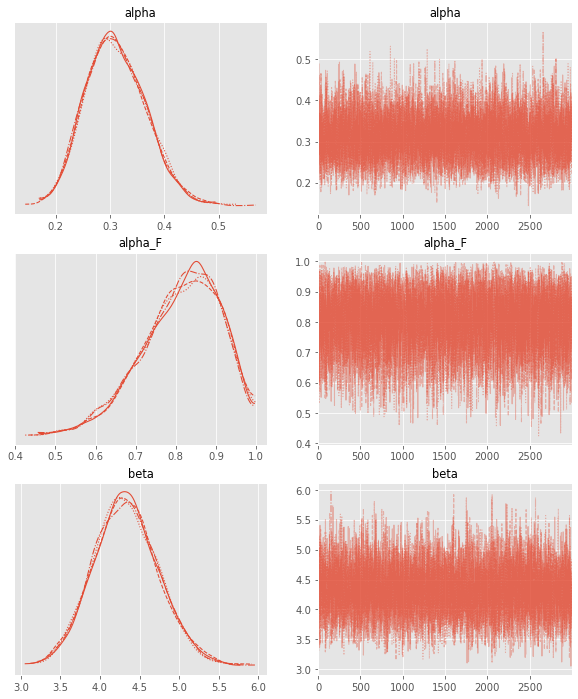

In [29]:
arviz.plot_trace(fit, var_names=('alpha', 'alpha_F', 'beta'), figsize=(10, 12));

## Model Comparison: Which model describes the behavioral data better?

### Methods
- Cross validation using test datasets
- Calculating information criteria

Here we select the best model by calculating Bayesian Information Criterion (BIC)

BIC $= -2 \log P(D | \Theta) + k \log n$

- $k$ : Number of free parameters in a model
- $n$ : Number of samples

In [42]:
bic_q = -2*q_ll + 2*np.log(len(actions))
bic_qf = -2*qf_ll + 3*np.log(len(actions))

In [45]:
print("BIC for Q Model:", bic_q)
print("BIC for Q-F Model:", bic_qf)
if bic_q > bic_qf:
    print("The best model: Q-F")
else:
    print("The best model: Q")

BIC for Q Model: 456.9799750798646
BIC for Q-F Model: 354.270373790605
The best model: Q-F
